**Importing Necessary Libraries**

In [281]:
! pip install tensorflow numpy scipy pillow matplotlib gdown

In [282]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.spatial import ConvexHull
from scipy.spatial import distance
import math
from PIL import Image
from itertools import combinations
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import gdown
import csv
import os
import zipfile

# Isolated Code


### Overview

The `ShapeDetector` class is a Python tool designed to detect and classify various geometric shapes from a set of 2D points. This class can identify circles, rectangles, stars, lines, and ellipses from given path data. It also provides functionality to merge similar shapes, update paths based on detected shapes, and visualize the results.

### **Key Features**

1.  **Shape Detection**:

    -   **Circles**: Detects circles based on a set of 2D points and calculates their center and radius.
    -   **Rectangles**: Identifies rectangles by evaluating potential vertex positions and verifying side lengths and diagonals.
    -   **Stars**: Recognizes star shapes by checking convex hull properties and ensuring the points are not collinear.
    -   **Lines**: Detects straight lines by evaluating the slope between consecutive points.
    -   **Ellipses**: Fits ellipses to a set of points and calculates parameters such as the center, major/minor axes, and rotation angle.
2.  **Merging Shapes**:

    -   Shapes that are close to each other or have similar properties can be merged, reducing redundancy and improving the accuracy of detected shapes.
3.  **Path Updates**:

    -   The class updates the original paths based on the detected shapes, enabling a more accurate representation of the shapes within the data.
4.  **Visualization**:

    -   The class includes methods for plotting the detected shapes and the original paths, providing a clear visual representation of the results.
5.  **Customizable Tolerance**:

    -   The tolerance level for shape detection can be adjusted, allowing users to fine-tune the sensitivity of the detection algorithms.

In [319]:
csv_path = 'isolated.csv'

In [320]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Load the CSV file and read its contents

path_XYs = read_csv(csv_path)

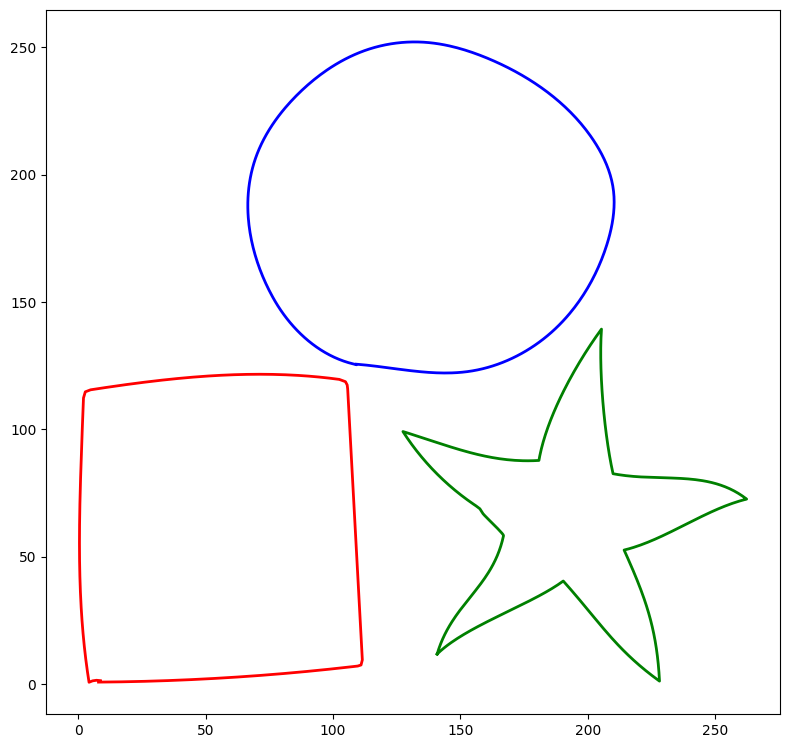

In [321]:
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Assuming path_XYs is already defined from the previous code
plot(path_XYs)

In [322]:
class ShapeDetector:
    """
    A class to detect and categorize shapes such as circles, ellipses, rectangles, stars, and lines
    from a given set of 2D points. The class also allows for fitting shapes to the detected points,
    merging similar shapes, and updating paths based on the detected shapes.

    Attributes:
    - path_XYs: List of lists of numpy arrays, where each numpy array represents a polygon.
    - tolerance: Tolerance value used to determine shape similarity and accuracy of shape detection.
    - circles: List to store detected circles.
    - rectangles: List to store detected rectangles.
    - stars: List to store detected stars.
    - lines: List to store detected lines.
    - ellipses: List to store detected ellipses.
    - modified_paths: List to store paths modified based on detected shapes.
    - final_modified_paths: List to store the final modified paths after shape detection and merging.

    Methods:
    - calc_R(xc, yc, X, Y): Compute the distance from the center of a circle to a given set of points.
    - f_2(c, X, Y): Calculate the algebraic distance between 2D points and a mean circle centered at (xc, yc).
    - fit_circle(X, Y): Fit a circle to a given set of points.
    - is_circle(X, Y): Check if a given set of points forms a circle.
    - fit_ellipse(X, Y): Fit an ellipse to a given set of points.
    - is_ellipse(X, Y): Check if a given set of points forms an ellipse.
    - calc_ellipse_residuals(X, Y, xc, yc, a, b, theta): Calculate residuals for the ellipse fit.
    - angle_between_vectors(v1, v2): Calculate the angle between two vectors.
    - is_right_angle(angle, tolerance=10): Check if an angle is close to 90 degrees with some tolerance.
    - distance(p1, p2): Calculate the distance between two points.
    - is_rectangle(points, tolerance=10): Check if a given set of points forms a rectangle.
    - fit_rectangle(X, Y): Fit a rectangle to a given set of points by calculating a bounding box.
    - angle_with_centroid(p, centroid): Calculate the angle between a point and the centroid.
    - are_points_collinear(points): Check if the given points are collinear.
    - is_star(points): Check if a given set of points forms a star shape.
    - generate_star(cx, cy, r, n=5): Generate points for a perfect star.
    - is_line(X, Y, tolerance=1.0, x_tolerance=10): Check if a given set of points forms a line.
    - line_length(X, Y, m, b): Calculate the length of the line segment defined by the points.
    - detect_shapes(): Detect and store the best fit parameters for circles, rectangles, stars, ellipses, and lines.
    - merge_shapes(): Merge shapes that are close to each other within the specified tolerance.
    - _merge_similar_shapes(shapes, num_params, is_line=False): Helper function to merge similar shapes based on their parameters.
    - update_paths(): Update the modified paths based on the detected and merged shapes.
    - connect_close_paths(max_distance=20): Connect paths if the distance between any combination of their start and end points is less than max_distance.
    - plot_shapes(): Plot the detected shapes along with the original paths.
    - print_parameters(): Print the detected shape parameters.
    - get_modified_paths(): Return the modified paths.
    - get_final_modified_paths(): Return the final modified paths with rectangles checked.
    """

    def __init__(self, path_XYs, tolerance=15):
        """
        Initialize the ShapeDetector with a set of paths and a tolerance value.

        Parameters:
        - path_XYs: List of lists of numpy arrays, where each numpy array represents a polygon.
        - tolerance: Tolerance value used for shape detection and merging (default is 15).
        """
        self.path_XYs = path_XYs
        self.tolerance = tolerance
        self.circles = []
        self.rectangles = []
        self.stars = []
        self.lines = []
        self.ellipses = []
        self.modified_paths = []
        self.final_modified_paths = []

    def calc_R(self, xc, yc, X, Y):
        """Compute the distance from the center of a circle to a given set of points."""
        return np.sqrt((X - xc) ** 2 + (Y - yc) ** 2)

    def f_2(self, c, X, Y):
        """Calculate the algebraic distance between the 2D points and the mean circle centered at c=(xc, yc)."""
        Ri = self.calc_R(c[0], c[1], X, Y)
        return Ri - Ri.mean()

    def fit_circle(self, X, Y):
        """Fit a circle to the points."""
        x_m = np.mean(X)
        y_m = np.mean(Y)
        center_estimate = x_m, y_m
        center, _ = leastsq(self.f_2, center_estimate, args=(X, Y))
        xc, yc = center
        Ri = self.calc_R(xc, yc, X, Y)
        R = Ri.mean()
        return xc, yc, R

    def is_circle(self, X, Y):
        """Check if a set of points forms a circle."""
        xc, yc, R = self.fit_circle(X, Y)
        distances = self.calc_R(xc, yc, X, Y)
        is_circle = np.all(np.isclose(distances, R, atol=R * 0.1))
        return is_circle, xc, yc, R

    def fit_ellipse(self, X, Y):
        """Fit an ellipse to the points."""
        x_m = np.mean(X)
        y_m = np.mean(Y)

        def ellipse_residuals(params, x, y):
            xc, yc, a, b, theta = params
            cost = np.cos(theta)
            sint = np.sin(theta)
            x_diff = x - xc
            y_diff = y - yc
            return ((x_diff * cost + y_diff * sint) / a) ** 2 + ((x_diff * sint - y_diff * cost) / b) ** 2 - 1

        # Initial guess
        initial_guess = (x_m, y_m, np.std(X), np.std(Y), 0)

        # Optimize the parameters
        result = leastsq(ellipse_residuals, initial_guess, args=(X, Y))
        xc, yc, a, b, theta = result[0]

        return xc, yc, a, b, theta

    def is_ellipse(self, X, Y):
        """Check if a set of points forms an ellipse."""
        xc, yc, a, b, theta = self.fit_ellipse(X, Y)
        residuals = self.calc_ellipse_residuals(X, Y, xc, yc, a, b, theta)
        #print(residuals)
        is_ellipse = np.all((residuals > 0.01) & (residuals < 1))
        return is_ellipse, xc, yc, a, b, theta

    def calc_ellipse_residuals(self, X, Y, xc, yc, a, b, theta):
        """Calculate residuals for the ellipse fit."""
        cost = np.cos(theta)
        sint = np.sin(theta)
        x_diff = X - xc
        y_diff = Y - yc
        return ((x_diff * cost + y_diff * sint) / a) ** 2 + ((x_diff * sint - y_diff * cost) / b) ** 2 - 1

    def angle_between_vectors(self, v1, v2):
        """Calculate the angle between two vectors."""
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        return np.degrees(angle)

    def is_right_angle(self, angle, tolerance=10):
        """Check if an angle is close to 90 degrees with some tolerance."""
        return np.isclose(angle, 90, atol=tolerance)

    def distance(self, p1, p2):
        """Calculate the distance between two points."""
        return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    def is_rectangle(self, points, tolerance=10):
        """Check if a set of points forms a rectangle."""
        x_coords = [p[0] for p in points]
        y_coords = [p[1] for p in points]

        xmin, xmax = min(x_coords), max(x_coords)
        ymin, ymax = min(y_coords), max(y_coords)

        # Define potential rectangle vertices
        vertices = [(xmin, ymin), (xmin, ymax), (xmax, ymin), (xmax, ymax)]
        for vertex in vertices:
            if not any(
                math.isclose(vertex[0], p[0], abs_tol=tolerance) and math.isclose(vertex[1], p[1], abs_tol=tolerance)
                for p in points):
                return False

        # Calculate all pairwise distances
        dists = []
        for i in range(4):
            for j in range(i + 1, 4):
                dists.append((self.distance(vertices[i], vertices[j]), (vertices[i], vertices[j])))

        # Sort distances
        dists.sort(key=lambda x: x[0])

        # The first 4 distances should be the sides (2 pairs of equal lengths)
        # The last 2 distances should be the diagonals (equal length)
        side1, side2, side3, side4 = dists[0][0], dists[1][0], dists[2][0], dists[3][0]
        diag1, diag2 = dists[4][0], dists[5][0]

        # Check if the sides are approximately equal in pairs and the diagonals are equal
        return (abs(side1 - side2) <= tolerance and
                abs(side3 - side4) <= tolerance and
                abs(side1 - side3) <= tolerance and
                abs(diag1 - diag2) <= tolerance)

    def fit_rectangle(self, X, Y):
        """Fit a rectangle to the points by calculating bounding box."""
        x_min, x_max = np.min(X), np.max(X)
        y_min, y_max = np.min(Y), np.max(Y)
        return x_min, x_max, y_min, y_max

    def angle_with_centroid(self, p, centroid):
        """Calculate the angle between a point and the centroid."""
        return math.atan2(p[1] - centroid[1], p[0] - centroid[0])

    def are_points_collinear(self, points):
        """Check if the given points are collinear."""
        def area(p1, p2, p3):
            return 0.5 * np.abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))

        n = len(points)
        if n < 3:
            return True

        for i in range(n - 2):
            if area(points[i], points[i + 1], points[i + 2]) < 10:
                return False

        return True

    def is_star(self, points):
        """Check if a set of points forms a star shape."""
        points = np.array(points)
        hull = ConvexHull(points)
        num_hull_points = len(hull.vertices)

        if self.are_points_collinear(points[hull.vertices]):
            return False, hull

        min_area = 1000
        if hull.volume < min_area:
            return False, hull

        return num_hull_points == 6, hull

    def generate_star(self, cx, cy, r, n=5):
        """Generate points for the perfect star."""
        angles = np.linspace(0, 2 * np.pi, 2 * n + 1)
        rads = np.zeros(angles.shape)
        rads[::2] = r
        rads[1::2] = r / 2
        x = cx + rads * np.cos(angles)
        y = cy + rads * np.sin(angles)
        return x, y

    def is_line(self, X, Y, tolerance=1.0, x_tolerance=10):
        """Check if a set of points forms a line."""
        if np.all(np.abs(X - np.mean(X)) <= x_tolerance):
            return True, float('inf'), np.mean(X)

        slopes = []
        for i in range(1, len(X)):
            dy = Y[i] - Y[i - 1]
            dx = X[i] - X[i - 1]
            slope = float('inf') if dx == 0 else dy / dx
            slopes.append(slope)

        slopes = np.array(slopes)
        return np.all(np.isclose(slopes, slopes[0], atol=tolerance)), round(np.mean(slopes), 0), np.mean(
            Y - round(np.mean(slopes), 0) * X)

    def line_length(self, X, Y, m, b):
        """Calculate the length of the line segment defined by the points."""
        if m == float('inf'):
            return np.max(Y) - np.min(Y)
        x_min, x_max = np.min(X), np.max(X)
        y_min, y_max = m * x_min + b, m * x_max + b
        return np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2)

    def detect_shapes(self):
        """Detect and store the best fit parameters for circles, rectangles, stars, ellipses, and lines."""
        path = 0

        for XYs in self.path_XYs:
            path += 1
            for XY in XYs:
                X = XY[:, 0]
                Y = XY[:, 1]
                shape_assigned = False
                print(f"Path is {path}")

                if not shape_assigned:
                    is_line, m, b = self.is_line(X, Y)
                    if is_line:
                        line_length = self.line_length(X, Y, m, b)
                        self.lines.append((m, b, line_length, X, Y))
                        shape_assigned = True

                if not shape_assigned:
                    is_star, hull = self.is_star(XY)
                    if is_star:
                        xc, yc = np.mean(X), np.mean(Y)
                        distances = self.calc_R(xc, yc, X, Y)
                        self.stars.append((xc, yc, np.mean(distances[-5:])))
                        shape_assigned = True

                if not shape_assigned:
                    is_circle, xc, yc, R = self.is_circle(X, Y)
                    if is_circle and R < 100:
                        self.circles.append((xc, yc, R))
                        shape_assigned = True

                if not shape_assigned and self.is_rectangle(XY):
                    x_min, x_max, y_min, y_max = self.fit_rectangle(X, Y)
                    self.rectangles.append((x_min, x_max, y_min, y_max))
                    shape_assigned = True

                if not shape_assigned:
                    is_ellipse, xc, yc, a, b, theta = self.is_ellipse(X, Y)
                    if is_ellipse:
                        self.ellipses.append((xc, yc, a, b, theta))
                        shape_assigned = True

                if not shape_assigned:
                    self.modified_paths.append([XY])

    def merge_shapes(self):
        """Merge shapes that are close to each other within the specified tolerance."""
        self.circles = self._merge_similar_shapes(self.circles, 3)
        self.rectangles = self._merge_similar_shapes(self.rectangles, 4)
        self.stars = self._merge_similar_shapes(self.stars, 3)
        self.ellipses = self._merge_similar_shapes(self.ellipses, 5)

    def _merge_similar_shapes(self, shapes, num_params, is_line=False):
        """Helper function to merge similar shapes based on their parameters."""
        if not shapes:
            return []

        merged_shapes = []
        used = [False] * len(shapes)

        for i, shape in enumerate(shapes):
            if used[i]:
                continue
            similar_shapes = [shape]
            for j, other_shape in enumerate(shapes):
                if i != j and not used[j]:
                    if all(np.isclose(shape[k], other_shape[k], atol=self.tolerance) for k in range(num_params)):
                        similar_shapes.append(other_shape)
                        used[j] = True
            mean_shape = np.mean(similar_shapes, axis=0)
            merged_shapes.append(mean_shape)

        return merged_shapes

    def update_paths(self):
        """Update the modified paths based on the detected and merged shapes."""
        for (xc, yc, R) in self.circles:
            theta = np.linspace(0, 2 * np.pi, 100)
            X_circle = xc + R * np.cos(theta)
            Y_circle = yc + R * np.sin(theta)
            self.modified_paths.append([np.column_stack((X_circle, Y_circle))])

        for (x_min, x_max, y_min, y_max) in self.rectangles:
            rect_X = [x_min, x_max, x_max, x_min, x_min]
            rect_Y = [y_min, y_min, y_max, y_max, y_min]
            self.modified_paths.append([np.column_stack((rect_X, rect_Y))])

        for (xc, yc, R) in self.stars:
            X_star, Y_star = self.generate_star(xc, yc, R)
            self.modified_paths.append([np.column_stack((X_star, Y_star))])

        for (m, b, _, X, Y) in self.lines:
            X_line = np.linspace(np.min(X), np.max(X), 100)
            if m == float('inf'):
                X_line = np.full(100, b)
                Y_line = np.linspace(np.min(Y), np.max(Y), 100)
            else:
                Y_line = m * X_line + b
            self.modified_paths.append([np.column_stack((X_line, Y_line))])

        for (xc, yc, a, b, theta) in self.ellipses:
            theta_vals = np.linspace(0, 2 * np.pi, 100)
            X_ellipse = xc + a * np.cos(theta_vals) * np.cos(theta) - b * np.sin(theta_vals) * np.sin(theta)
            Y_ellipse = yc + a * np.cos(theta_vals) * np.sin(theta) + b * np.sin(theta_vals) * np.cos(theta)
            self.modified_paths.append([np.column_stack((X_ellipse, Y_ellipse))])

    def connect_close_paths(self, max_distance=20):
        """Connect paths if the distance between any combination of their start and end points is less than max_distance."""
        connected_paths = []
        if not self.modified_paths:
            return connected_paths

        current_path = self.modified_paths[0][0]

        for next_path in self.modified_paths[1:]:
            next_path = next_path[0]
            end_point = current_path[-1]
            start_point = current_path[0]
            next_start_point = next_path[0]
            next_end_point = next_path[-1]

            distances = [
                np.linalg.norm(end_point - next_start_point),
                np.linalg.norm(start_point - next_end_point),
                np.linalg.norm(start_point - next_start_point),
                np.linalg.norm(end_point - next_end_point)
            ]

            min_distance = min(distances)
            min_index = distances.index(min_distance)

            if min_distance < max_distance:
                if min_index == 0:  # end_point to next_start_point
                    current_path = np.vstack((current_path, next_path))
                elif min_index == 1:  # start_point to next_end_point
                    current_path = np.vstack((next_path[::-1], current_path))
                elif min_index == 2:  # start_point to next_start_point
                    current_path = np.vstack((next_path[::-1], current_path))
                elif min_index == 3:  # end_point to next_end_point
                    current_path = np.vstack((current_path, next_path[::-1]))
            else:
                connected_paths.append([current_path])
                current_path = next_path

        connected_paths.append([current_path])
        self.modified_paths = connected_paths

    def plot_shapes(self):
        """Plot the detected shapes along with the original paths."""
        plt.figure(figsize=(8, 8))

        for path in self.modified_paths:
            for XY in path:
                plt.plot(XY[:, 0], XY[:, 1], linewidth=2)

        plt.gca().set_aspect('equal')
        plt.legend()
        plt.title('Detected Shapes and Original Paths')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.show()

    def print_parameters(self):
        """Print the detected shape parameters."""
        for i, (xc, yc, R) in enumerate(self.circles):
            print(f"Circle {i+1}: Center=({xc}, {yc}), Radius={R}")

        for i, (x_min, x_max, y_min, y_max) in enumerate(self.rectangles):
            print(f"Rectangle {i+1}: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")

        for i, (xc, yc, R) in enumerate(self.stars):
            print(f"Star {i+1}: Center=({xc}, {yc}), Radius={R}")

        for i, (m, b, length, _, __) in enumerate(self.lines):
            print(f"Line {i+1}: slope={m}, intercept={b}, length={length}")

        for i, (xc, yc, a, b, theta) in enumerate(self.ellipses):
            print(f"Ellipse {i+1}: Center=({xc}, {yc}), Major Axis={a}, Minor Axis={b}, Rotation={theta} radians")

    def get_modified_paths(self):
        """Return the modified paths."""
        return self.modified_paths

    def get_final_modified_paths(self):
        """Return the final modified paths with rectangles checked."""
        return self.final_modified_paths


def plot(paths_XYs):
    """Plot the given paths."""
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()


def check_for_rectangles(paths, shape_detector):
    """Check if any paths form a rectangle and update the final modified paths."""
    final_paths = []
    rectangles = []

    for path in paths:
        for XY in path:
            if len(XY) >= 4:  # Ensure there are at least 4 points to form a rectangle
                X, Y = XY[:, 0], XY[:, 1]

                # Directly check if the path forms a rectangle
                if shape_detector.is_rectangle(XY, tolerance=5):
                    x_min, x_max, y_min, y_max = shape_detector.fit_rectangle(X, Y)
                    rectangles.append((x_min, x_max, y_min, y_max))
                    rect_X = [x_min, x_max, x_max, x_min, x_min]
                    rect_Y = [y_min, y_min, y_max, y_max, y_min]
                    final_paths.append([np.column_stack((rect_X, rect_Y))])
                else:
                    final_paths.append(path)  # If it's not a rectangle, keep the original path
            else:
                final_paths.append(path)  # If there are fewer than 4 points, keep the original path

    shape_detector.final_modified_paths = final_paths
    return rectangles


Intialization of the class and calling all functions

Path is 1
Path is 2
Path is 3


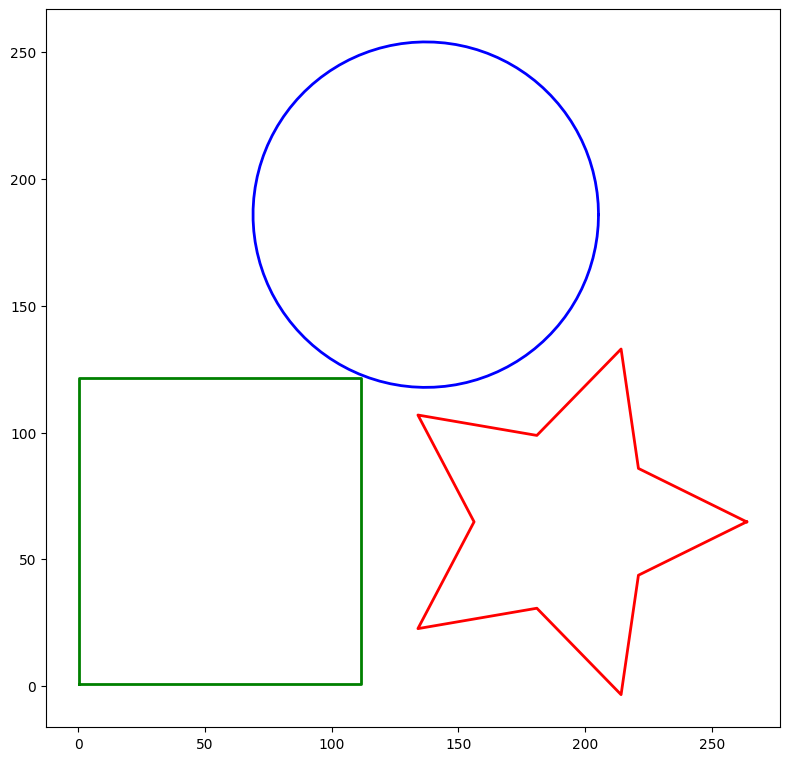

Circle 1: Center=(137.08855982039236, 185.928774559048), Radius=68.13670285968323
Rectangle 1: x_min=0.49957937002182007, x_max=111.49099731445312, y_min=0.7789999842643738, y_max=121.62493133544922
Star 1: Center=(191.98106037486684, 64.77437598748641), Radius=71.66964327890726
Modified Paths:


In [323]:

# Instantiate the ShapeDetector class
shape_detector = ShapeDetector(path_XYs)

# Detect shapes from the points
shape_detector.detect_shapes()

# Merge similar shapes based on the specified tolerance
shape_detector.merge_shapes()

# Update the paths based on the detected and merged shapes
shape_detector.update_paths()
shape_detector.connect_close_paths()

# Get the modified paths
modified_paths = shape_detector.get_modified_paths()
#plot(modified_paths)

# Check for rectangles in the modified paths
rectangles = check_for_rectangles(shape_detector.modified_paths, shape_detector)

# Plot the final modified paths
plot(shape_detector.get_final_modified_paths())

# Print the parameters of the detected shapes
shape_detector.print_parameters()

# Print the detected rectangles
for i, (x_min, x_max, y_min, y_max) in enumerate(rectangles):
    print(f"Rectangle {i+1}: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")

print("Modified Paths:")

# Fragmentation

## Overview
==============

The `SymmetryFinder` class provides methods to detect and visualize symmetry in 2D polygonal paths. It can identify vertical, horizontal, and general symmetry lines, as well as the center of radial symmetry in a given set of 2D paths.

Features
--------

-   **Vertical Symmetry Detection**: Finds the vertical line of symmetry for the entire figure.
-   **Horizontal Symmetry Detection**: Finds the horizontal line of symmetry for the entire figure.
-   **General Symmetry Detection**: Identifies the best symmetry line with a specific slope and intercept.
-   **Radial Symmetry Detection**: Finds the center of radial symmetry for the figure.
-   **Visualization**: Plot the paths along with the detected symmetry lines and radial symmetry center.

Enter the csv file path

In [293]:
csv_path = 'frag0.csv'

In [294]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Load the CSV file and read its contents

path_XYs = read_csv(csv_path)


Visualising the paths

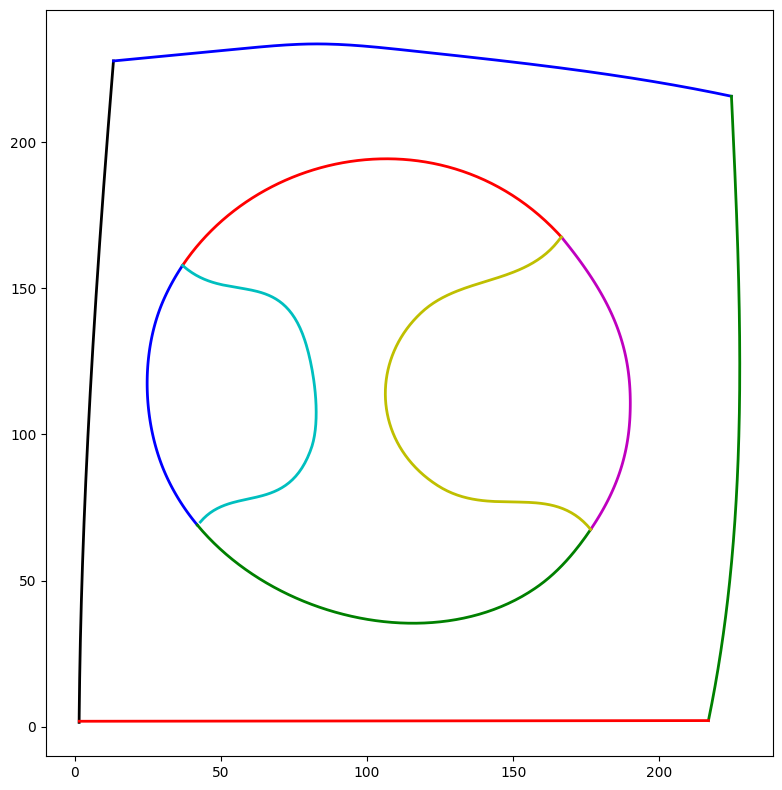

In [295]:
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Assuming path_XYs is already defined from the previous code
plot(path_XYs)



In [296]:
class SymmetryFinder:
    def __init__(self, path_XYs, threshold=5):
        """
        Initialize the SymmetryFinder with a set of paths and a threshold.

        Parameters:
        - path_XYs: List of lists of numpy arrays, where each numpy array represents a polygon.
        - threshold: Multiplier used for defining the range around the center to search for symmetry lines.
        """
        self.path_XYs = path_XYs
        self.threshold = threshold

    def find_best_horizontal_symmetry_line(self):
        """
        Find the horizontal line that best divides the paths into symmetric halves.

        Returns:
        - best_y: The y-coordinate of the best horizontal symmetry line.
        - best_symmetry_score: The symmetry score for the best horizontal symmetry line.
        """
        all_y_coords = np.concatenate([poly[:, 1] for paths in self.path_XYs for poly in paths])
        y_min, y_max = np.min(all_y_coords), np.max(all_y_coords)

        height = y_max - y_min
        mid_y = (y_min + y_max) / 2
        y_range = np.linspace(mid_y - self.threshold * height, mid_y + self.threshold * height, 100)

        best_symmetry_score = float('inf')
        best_y = None

        for y in y_range:
            total_distance = 0
            total_points = 0
            for paths in self.path_XYs:
                for poly in paths:
                    distances = []
                    for point in poly:
                        mirrored_point = np.array([point[0], 2 * y - point[1]])
                        distances.append(np.min(np.linalg.norm(poly - mirrored_point, axis=1)))
                    total_distance += np.sum(distances)
                    total_points += len(distances)

            avg_distance = total_distance / total_points
            normalized_score = avg_distance / height
            if normalized_score < best_symmetry_score:
                best_symmetry_score = normalized_score
                best_y = y

        return best_y, best_symmetry_score

    def find_best_vertical_symmetry_line(self):
        """
        Find the vertical line that best divides the paths into symmetric halves.

        Returns:
        - best_x: The x-coordinate of the best vertical symmetry line.
        - best_symmetry_score: The symmetry score for the best vertical symmetry line.
        """
        all_x_coords = np.concatenate([poly[:, 0] for paths in self.path_XYs for poly in paths])
        x_min, x_max = np.min(all_x_coords), np.max(all_x_coords)

        width = x_max - x_min
        mid_x = (x_min + x_max) / 2
        x_range = np.linspace(mid_x - self.threshold * width, mid_x + self.threshold * width, 100)

        best_symmetry_score = float('inf')
        best_x = None

        for x in x_range:
            total_distance = 0
            total_points = 0
            for paths in self.path_XYs:
                for poly in paths:
                    distances = []
                    for point in poly:
                        mirrored_point = np.array([2 * x - point[0], point[1]])
                        distances.append(np.min(np.linalg.norm(poly - mirrored_point, axis=1)))
                    total_distance += np.sum(distances)
                    total_points += len(distances)

            avg_distance = total_distance / total_points
            normalized_score = avg_distance / width
            if normalized_score < best_symmetry_score:
                best_symmetry_score = normalized_score
                best_x = x

        return best_x, best_symmetry_score

    def find_symmetry_line_and_score(self, slope_threshold=30, num_slope_steps=100):
        """
        Find the general symmetry line, not constrained to horizontal or vertical, that best divides the paths into symmetric halves.

        Parameters:
        - slope_threshold: The range around the initial slope to explore.
        - num_slope_steps: The number of steps to take within the slope range.

        Returns:
        - best_slope: The slope of the best symmetry line.
        - best_intercept: The y-intercept of the best symmetry line.
        - best_symmetry_score: The symmetry score for the best general symmetry line.
        """
        all_points = np.concatenate([poly for paths in self.path_XYs for poly in paths])

        top_left = np.array([np.min(all_points[:, 0]), np.max(all_points[:, 1])])
        bottom_right = np.array([np.max(all_points[:, 0]), np.min(all_points[:, 1])])

        initial_slope = (bottom_right[1] - top_left[1]) / (bottom_right[0] - top_left[0])
        intercept = top_left[1] - initial_slope * top_left[0]

        best_symmetry_score = float('inf')
        best_slope = initial_slope
        best_intercept = intercept

        for slope in np.linspace(initial_slope - slope_threshold, initial_slope + slope_threshold, num_slope_steps):
            total_distance = 0
            for point in all_points:
                x, y = point
                mirrored_point = np.array([
                    (x + slope * y - slope * intercept) / (1 + slope ** 2),
                    (slope * x + y - intercept) / (1 + slope ** 2)
                ])

                distance = np.min(np.linalg.norm(all_points - mirrored_point, axis=1))
                total_distance += distance

            figure_size = np.linalg.norm(bottom_right - top_left)
            symmetry_score = total_distance / (len(all_points) * figure_size)

            if symmetry_score < best_symmetry_score:
                best_symmetry_score = symmetry_score
                best_slope = slope
                best_intercept = intercept

        return best_slope, best_intercept, best_symmetry_score

    def find_best_radial_symmetry_center(self, search_radius=100, num_steps=20):
        """
        Find the center of radial symmetry by exploring different radial positions around the initial center.

        Parameters:
        - search_radius: The radius around the initial center to search.
        - num_steps: The number of steps to take in both radial and angular directions.

        Returns:
        - best_center: The coordinates of the best radial symmetry center.
        - best_symmetry_score: The symmetry score for the best radial symmetry center.
        """
        all_points = np.concatenate([poly for paths in self.path_XYs for poly in paths])

        x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
        y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])

        cx_init = (x_min + x_max) / 2
        cy_init = (y_min + y_max) / 2

        diagonal_distance = np.linalg.norm([x_max - x_min, y_max - y_min])

        best_symmetry_score = float('inf')
        best_center = (cx_init, cy_init)

        for radius in np.linspace(0, search_radius, num_steps):
            for angle in np.linspace(0, 2 * np.pi, num_steps):
                cx = cx_init + radius * np.cos(angle)
                cy = cy_init + radius * np.sin(angle)

                total_distance = 0
                for point in all_points:
                    x, y = point
                    mirrored_point = np.array([2 * cx - x, 2 * cy - y])
                    total_distance += np.min(np.linalg.norm(all_points - mirrored_point, axis=1))

                avg_distance = total_distance / len(all_points)
                normalized_score = avg_distance / diagonal_distance

                if normalized_score < best_symmetry_score:
                    best_symmetry_score = normalized_score
                    best_center = (cx, cy)

        return best_center, best_symmetry_score

    def plot_paths_with_vertical_horizontal_lines(self, best_x, best_y):
        """
        Plot the paths with the best vertical and horizontal lines of symmetry.

        Parameters:
        - best_x: The x-coordinate of the best vertical symmetry line.
        - best_y: The y-coordinate of the best horizontal symmetry line.
        """
        plt.figure()
        for paths in self.path_XYs:
            for poly in paths:
                plt.plot(poly[:, 0], poly[:, 1], 'b-')

        if best_x is not None:
            plt.axvline(x=best_x, color='r', linestyle='--', label=f'Vertical symmetry line at x = {best_x:.2f}')

        if best_y is not None:
            plt.axhline(y=best_y, color='g', linestyle='--', label=f'Horizontal symmetry line at y = {best_y:.2f}')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Paths with Vertical and Horizontal Symmetry Lines')
        plt.legend()
        plt.show()

    def plot_paths_with_symmetry_line(self, slope, intercept, symmetry_score):
        """
        Plot the paths along with the calculated general symmetry line.

        Parameters:
        - slope: The slope of the symmetry line.
        - intercept: The y-intercept of the symmetry line.
        - symmetry_score: The symmetry score associated with the line.
        """
        all_points = np.concatenate([poly for paths in self.path_XYs for poly in paths])

        plt.figure()
        for paths in self.path_XYs:
            for poly in paths:
                plt.plot(poly[:, 0], poly[:, 1], 'b-')

        if slope is not None and intercept is not None:
            x_vals = np.linspace(np.min(all_points[:, 0]), np.max(all_points[:, 0]), 100)
            y_vals = slope * x_vals + intercept
            plt.plot(x_vals, y_vals, 'm--', label=f'Symmetry line at y = {slope:.2f}x + {intercept:.2f}')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Paths with Symmetry Line (Symmetry Score: {symmetry_score:.2f})')
        plt.legend()
        plt.show()

    def plot_paths_with_radial_center(self, best_center,best_radial_score):
        """
        Plot the paths along with the best found radial symmetry center.

        Parameters:
        - best_center: Tuple of two floats representing the coordinates (x, y) of the radial symmetry center.
        - best_radial_score: Float representing the radial symmetry score associated with the center.

        This method visualizes the paths provided to the SymmetryFinder along with the calculated radial symmetry center.
        The radial symmetry center is highlighted on the plot, and the symmetry score is included in the title.
        """
        all_points = np.concatenate([poly for paths in self.path_XYs for poly in paths])

        plt.figure()
        for paths in self.path_XYs:
            for poly in paths:
                plt.plot(poly[:, 0], poly[:, 1], 'b-')

        if best_center is not None:
            plt.plot(best_center[0], best_center[1], 'ro', label='Radial Symmetry Center', markersize=10)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Paths with Radial Symmetry Center with a score of {best_radial_score}')

        # Move the label to the bottom of the plot
        plt.legend(loc='lower center')
        plt.show()


Initializing the class

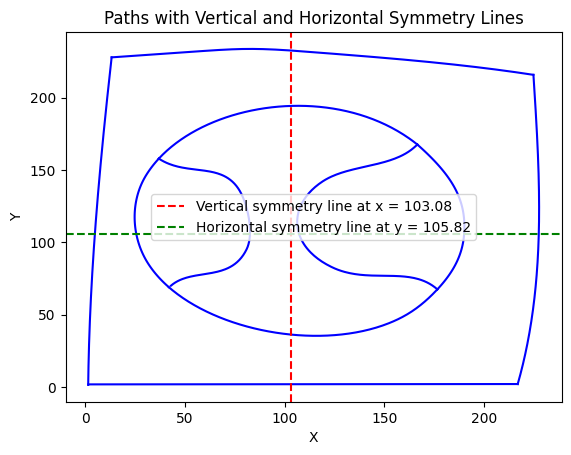

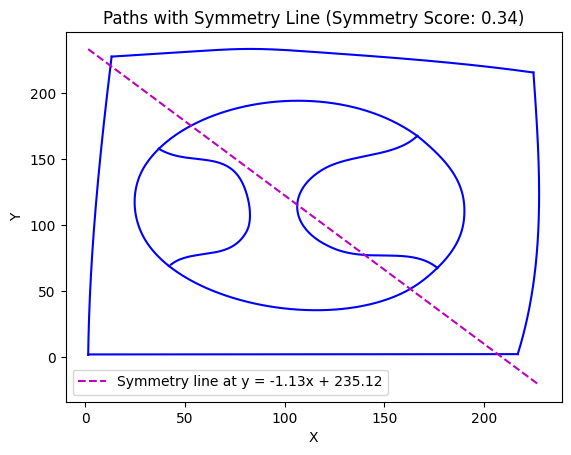

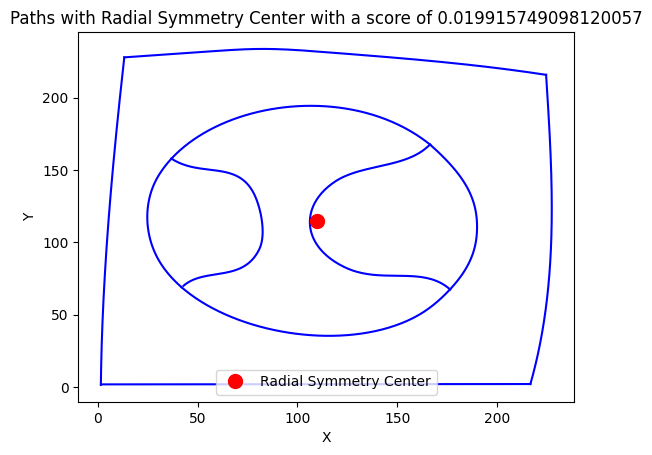

In [297]:
# Create an instance of the SymmetryFinder class
symmetry_finder = SymmetryFinder(path_XYs)

# Find the best vertical and horizontal lines of symmetry for the entire figure
best_x, best_vertical_score = symmetry_finder.find_best_vertical_symmetry_line()
best_y, best_horizontal_score = symmetry_finder.find_best_horizontal_symmetry_line()

# Find the best symmetry line with slope and intercept
slope, intercept, symmetry_score = symmetry_finder.find_symmetry_line_and_score(slope_threshold=0.1, num_slope_steps=10)

# Find the best radial symmetry center for the entire figure
best_center, best_radial_score = symmetry_finder.find_best_radial_symmetry_center(search_radius=100, num_steps=20)

# Plot the paths with the symmetry lines and radial symmetry center
symmetry_finder.plot_paths_with_vertical_horizontal_lines(best_x, best_y)
symmetry_finder.plot_paths_with_symmetry_line(slope, intercept, symmetry_score)
symmetry_finder.plot_paths_with_radial_center(best_center,best_radial_score)

# Occlusion


## Connected Occlusion

###Overview
--------

The `ConnectedOcclusion` class is designed to process a set of 2D paths, identifying common points between them, generating smooth curves that connect these points, and modifying the paths accordingly. The class also allows for the visualization of the original and modified paths, and saves the modified paths to a CSV file.

Features
--------

-   **Identify Common Points**: The class identifies common points between different paths based on a specified distance threshold.
-   **Generate Smooth Curves**: Using the mean radius calculated for every `n` points, smooth curves are generated between the common points of different paths.
-   **Modify Paths**: The original paths are modified by inserting the generated smooth curves between the common points.
-   **Visualization**: The modified paths, along with the generated curves, are plotted for visualization.
-   **Save Modified Paths**: The modified paths are saved to a CSV file.

In [315]:
csv_path = 'occlusion1.csv'

In [316]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Load the CSV file and read its contents

path_XYs = read_csv(csv_path)


2


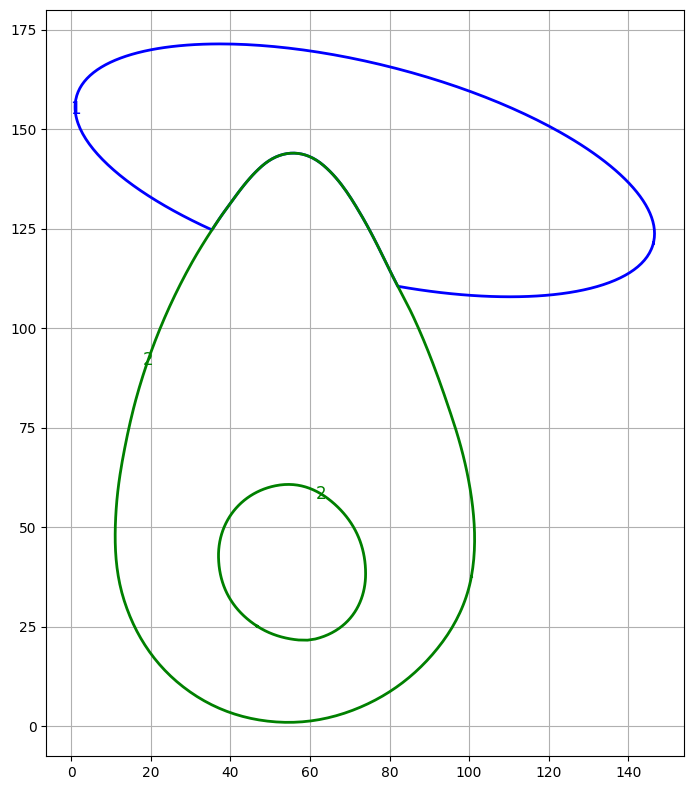

In [317]:
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
            # Annotate the path with its number
            midpoint_index = len(XY) // 2
            midpoint = XY[midpoint_index]
            ax.text(midpoint[0], midpoint[1], str(i+1), fontsize=12, color=c, ha='center', va='center')
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()
print(len(path_XYs))
# Assuming path_XYs is already defined from the previous code
# Example data for testing
plot(path_XYs)



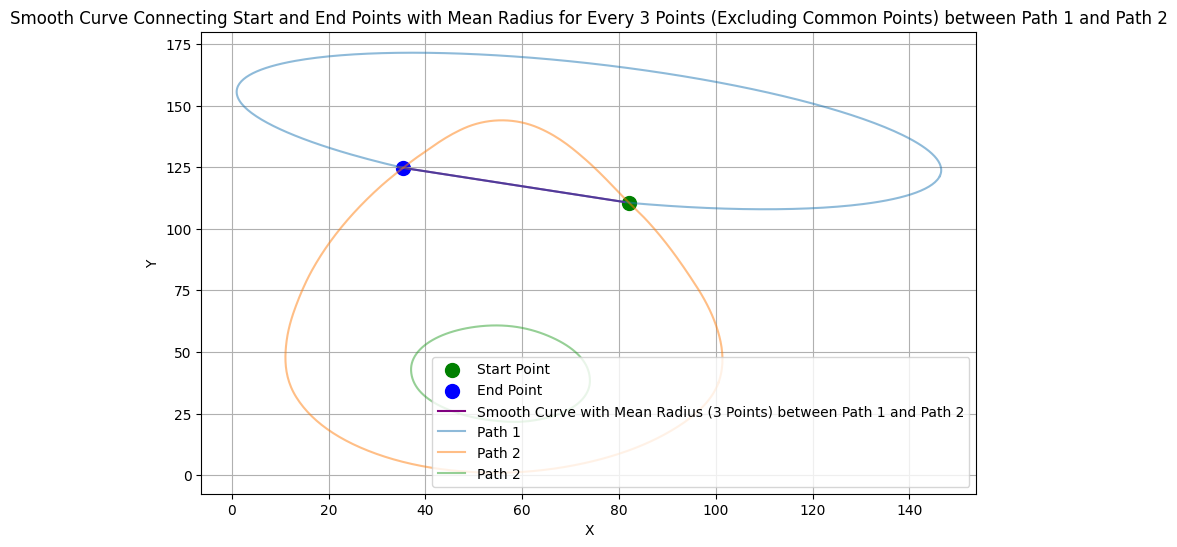

In [318]:
class ConnectedOcclusion:
    def __init__(self, path_XYs, threshold=0.2):
        """
        Initialize the ConnectedOcclusion class.

        Args:
            path_XYs (list): A list of paths, where each path is represented as a list of 2D points.
            threshold (float): The maximum distance between points in different paths to be considered common.
        """
        self.path_XYs = path_XYs
        self.threshold = threshold

    def calculate_radii_every_n_points(self, path, n):
        """
        Calculate the mean radius of the path for every n points.

        Args:
            path (ndarray): The array of 2D points representing a path.
            n (int): The number of points to consider for each segment.

        Returns:
            list: A list of mean radii for each segment of n points.
        """
        radii = []
        for i in range(0, len(path) - n, n):
            segment = path[i:i + n]
            distances = np.linalg.norm(segment - segment[0], axis=1)
            radii.append(np.mean(distances))
        return radii

    def find_common_points_with_threshold(self, path_1, path_2):
        """
        Find common points between two paths within the specified threshold.

        Args:
            path_1 (ndarray): The array of 2D points representing the first path.
            path_2 (ndarray): The array of 2D points representing the second path.

        Returns:
            ndarray: An array of common points found between the two paths.
        """
        common_points = []
        for point_1 in path_1:
            for point_2 in path_2:
                distance = np.linalg.norm(point_1 - point_2)
                if distance <= self.threshold:
                    common_points.append(((point_1 + point_2) / 2).tolist())
        return np.array(common_points)

    def process_paths(self):
        """
        Process all paths by finding common points, generating new intermediate points,
        modifying the paths, and plotting the results.
        """
        for idx1, idx2 in combinations(range(len(self.path_XYs)), 2):
            path_1 = np.vstack(self.path_XYs[idx1])
            path_2 = np.vstack(self.path_XYs[idx2])
            common_points_threshold = self.find_common_points_with_threshold(path_1, path_2)

            if common_points_threshold.size == 0:
                print(f"No common points found between paths {idx1 + 1} and {idx2 + 1} within the threshold")
                continue

            path_1_unique = np.array([point for point in path_1 if tuple(point) not in common_points_threshold])
            path_2_unique = np.array([point for point in path_2 if tuple(point) not in common_points_threshold])

            if path_1_unique.size == 0 or path_2_unique.size == 0:
                print(f"Path {idx1 + 1} or Path {idx2 + 1} has no unique points after removing common points")
                continue

            start_point = common_points_threshold[0]
            end_point = common_points_threshold[-1]

            radii_1_3points = self.calculate_radii_every_n_points(path_1_unique, 3)
            radii_2_3points = self.calculate_radii_every_n_points(path_2_unique, 3)
            mean_radii_1_3points = np.mean(radii_1_3points)
            mean_radii_2_3points = np.mean(radii_2_3points)
            mean_radius_value_3points = (mean_radii_1_3points + mean_radii_2_3points) / 2

            num_intermediate_points = 300
            x_new_3points = np.linspace(start_point[0], end_point[0], num_intermediate_points)
            y_new_3points = np.linspace(start_point[1], end_point[1], num_intermediate_points)
            angle = np.arctan2(end_point[1] - start_point[1], end_point[0] - start_point[0])
            x_offset_3points = mean_radius_value_3points * np.cos(angle)
            y_offset_3points = mean_radius_value_3points * np.sin(angle)
            x_intermediate_3points = x_new_3points + x_offset_3points
            y_intermediate_3points = y_new_3points + y_offset_3points

            # Generate the new points to insert
            new_points = np.vstack((x_intermediate_3points, y_intermediate_3points)).T

            # Determine the insertion index range for the new points in path_1
            start_idx = np.argmin(np.linalg.norm(path_1 - start_point, axis=1))
            end_idx = np.argmin(np.linalg.norm(path_1 - end_point, axis=1))

            # Insert the new points into path_1 at the correct position
            path_1_modified = np.vstack((path_1[:start_idx], new_points, path_1[end_idx:]))

            # Replace the original path_1 with the modified one
            self.path_XYs[idx1] = [path_1_modified]

            # Plot the modified paths
            self.plot_paths(idx1, idx2, start_point, end_point, x_intermediate_3points, y_intermediate_3points)

        # Save the modified paths
        self.save_modified_paths()

    def save_modified_paths(self):
        """
        Save the modified paths to a CSV file named 'occlusion1_modified.csv'.
        The file will contain the path index, segment index, and X and Y coordinates of each point.
        """
        output_data = []
        for idx, path_segments in enumerate(self.path_XYs, start=1):
            for segment_idx, segment in enumerate(path_segments, start=1):
                for point in segment:
                    output_data.append([idx, segment_idx, point[0], point[1]])

        output_data = np.array(output_data)
        np.savetxt('occlusion1_modified.csv', output_data, delimiter=',', fmt='%d,%d,%f,%f')

    def plot_paths(self, idx1, idx2, start_point, end_point, x_intermediate_3points, y_intermediate_3points):
        """
        Plot the paths and the generated intermediate points.

        Args:
            idx1 (int): The index of the first path.
            idx2 (int): The index of the second path.
            start_point (ndarray): The start point of the connection between the two paths.
            end_point (ndarray): The end point of the connection between the two paths.
            x_intermediate_3points (ndarray): The X coordinates of the intermediate points.
            y_intermediate_3points (ndarray): The Y coordinates of the intermediate points.
        """
        plt.figure(figsize=(10, 6))

        plt.scatter(start_point[0], start_point[1], color='green', label='Start Point', s=100)
        plt.scatter(end_point[0], end_point[1], color='blue', label='End Point', s=100)

        plt.plot(x_intermediate_3points, y_intermediate_3points, color='purple',
                 label=f'Smooth Curve with Mean Radius (3 Points) between Path {idx1 + 1} and Path {idx2 + 1}')

        for segment in self.path_XYs[idx1]:
            plt.plot(segment[:, 0], segment[:, 1], label=f'Path {idx1 + 1}', alpha=0.5)

        for segment in self.path_XYs[idx2]:
            plt.plot(segment[:, 0], segment[:, 1], label=f'Path {idx2 + 1}', alpha=0.5)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Smooth Curve Connecting Start and End Points with Mean Radius for Every 3 Points '
                  f'(Excluding Common Points) between Path {idx1 + 1} and Path {idx2 + 1}')
        plt.legend()
        plt.grid(True)
        plt.show()

path_processor = ConnectedOcclusion(path_XYs=path_XYs, threshold=0.2)
path_processor.process_paths()


## Disconnected Occlusion

###Overview
--------

This project is focused on processing and analyzing image data using a pre-trained ResNet50 model for feature extraction. The project identifies the nearest image in a dataset by calculating the Euclidean distance between the features of an input image and the images in the dataset. Additionally, the project provides functionality for reading and processing path data from a CSV file and visualizing it.


Project Structure
-----------------

-   `occlusion2.csv`: A CSV file containing path data for visualization.
-   `dataset_images.zip`: A zipped folder containing the dataset images.
-   `test.jpg`: An input image used to find the nearest image in the dataset.
-   `dataset_features.npy`: A NumPy file where the extracted features of the dataset images are stored.
-   `nearest_image_coordinates.csv`: A CSV file containing pixel coordinates of the nearest image.
-   `Disconnected_Occlusion.py`: The main Python script containing all the functions and code.

In [302]:
csv_path = 'occlusion2.csv'

In [303]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Load the CSV file and read its contents

path_XYs = read_csv(csv_path)

In [304]:
def plot(paths_XYs, output_path='test.jpg'):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
            # Annotate the path with its number
            midpoint_index = len(XY) // 2
            midpoint = XY[midpoint_index]
            #ax.text(midpoint[0], midpoint[1], str(i+1), fontsize=12, color=c, ha='center', va='center')
    ax.set_aspect('equal')
    plt.savefig(output_path)
    plt.close()
# Assuming path_XYs is already defined from the previous code
# Example data for testing
plot(path_XYs)

In [305]:
file_id = '1AY7eJx0J8xb_Ravi16cjKcQyy5v0Pn97'  # Replace with your file ID
url = f'https://drive.google.com/uc?id={file_id}'
output = 'dataset_images.zip'  # The name of the ZIP file to be saved in the current directory
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('.')

Downloading...
From: https://drive.google.com/uc?id=1AY7eJx0J8xb_Ravi16cjKcQyy5v0Pn97
To: /content/dataset_images.zip
100%|██████████| 239k/239k [00:00<00:00, 5.46MB/s]


In [306]:
# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract features from a grayscale image converted to RGB format
def extract_features(img_path):
    try:
        # Load the image in grayscale mode
        img = image.load_img(img_path, target_size=(224, 224), color_mode="grayscale")

        # Convert the grayscale image to a numpy array
        img_data = image.img_to_array(img)

        # Convert the grayscale image (single channel) to RGB by repeating the channels
        img_data = np.repeat(img_data, 3, axis=-1)  # Repeat the grayscale channel 3 times to create an RGB image

        # Expand dimensions to match the input shape for the model
        img_data = np.expand_dims(img_data, axis=0)

        # Preprocess the image to match the format expected by ResNet50
        img_data = preprocess_input(img_data)

        # Predict features using the pre-trained ResNet50 model
        features = model.predict(img_data)

        # Return the flattened feature vector
        return features.flatten()
    except UnidentifiedImageError as e:
        print(f"Cannot process {img_path}: {e}")
        return None
    except Exception as e:
        print(f"An error occurred while processing {img_path}: {e}")
        return None

In [307]:
def remove_ds_store(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == '.DS_Store':
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Removed: {file_path}")
                except Exception as e:
                    print(f"Error removing {file_path}: {e}")

# Example usage:
remove_ds_store('dataset_images/')

Removed: dataset_images/.DS_Store


In [308]:
# Path to the dataset images folder
dataset_images_path = 'dataset_images/'
dataset_images = [os.path.join(dataset_images_path, img) for img in os.listdir(dataset_images_path) if not os.path.isdir(os.path.join(dataset_images_path, img))]

dataset_features = []

for img_path in dataset_images:
    try:
        features = extract_features(img_path)
        dataset_features.append(features)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

dataset_features = np.array(dataset_features)
np.save('dataset_features.npy', dataset_features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


In [309]:
input_image_path = 'test.jpg'
input_features = extract_features(input_image_path)
input_features = input_features.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


File: dataset_images/Image9.png, Distance: 45.98033142089844
File: dataset_images/Image3.png, Distance: 42.076995849609375
File: dataset_images/Image8.png, Distance: 44.563812255859375
File: dataset_images/Image2.png, Distance: 63.12019729614258
File: dataset_images/Image6.png, Distance: 41.48880386352539
File: dataset_images/Image1.png, Distance: 42.43537902832031
File: dataset_images/Image10.png, Distance: 46.09273910522461
File: dataset_images/Image7.png, Distance: 48.8699836730957
File: dataset_images/Image4.jpg, Distance: 10.759147644042969
File: dataset_images/Image5.png, Distance: 46.17498016357422
The nearest image is: dataset_images/Image4.jpg


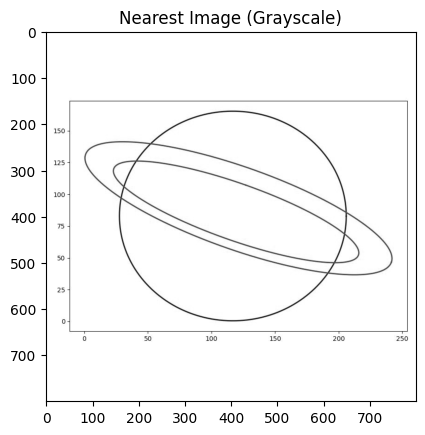

In [310]:
# Compute distances and store them with file names
distances = []
for img_path, features in zip(dataset_images, dataset_features):
    dist = distance.euclidean(input_features, features.flatten())
    distances.append(dist)
    print(f"File: {img_path}, Distance: {dist}")

# Find the index of the smallest distance (nearest image)
nearest_image_index = np.argmin(distances)
nearest_image_path = dataset_images[nearest_image_index]

print(f'The nearest image is: {nearest_image_path}')

# Load the nearest image
nearest_image = Image.open(nearest_image_path)

# Assuming nearest_image is a PIL Image, convert it to numpy array to get coordinates
# Here, we assume coordinates are pixels' positions or some derived values.
# In a typical scenario, coordinates could refer to specific feature points or pixel locations.

# Convert image to grayscale (if needed)
nearest_image_gray = nearest_image.convert('L')

# Get image size
width, height = nearest_image_gray.size

# Example: Create a list of coordinates for demonstration (you may need to adapt this based on your actual needs)
coordinates = [(x, y) for y in range(height) for x in range(width)]

# Write coordinates to a CSV file
output_csv_path = 'nearest_image_coordinates.csv'
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['X', 'Y'])  # Write the header
    for x, y in coordinates:
        writer.writerow([x, y])

# Display the nearest image in grayscale
plt.imshow(nearest_image_gray, cmap='gray')
plt.title("Nearest Image (Grayscale)")
plt.show()